In [6]:
import os

import argparse
from collections import defaultdict
import transformers
import numpy as np
import torch
import torch.nn as nn
from pytorch_lightning import LightningModule
from torch import optim
# from torchmetrics import F1
from transformers import ViTModel
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
import math
import json

## Dataset

In [7]:
class SummaryDataset(Dataset):
    def __init__(self, video_dir, directory, video_features_file, max_seq_len=250):
        self.directory = directory
        self.video_names = self.get_video_names(video_dir)
        self.video_features_file = video_features_file
        self.max_seq_len = max_seq_len

        # Because we can't use DDP with IterableDataset,
        # data must be pre-chunked to combat OOM.
        self.label_files = self.prefetch_label_files()
        self.data_size, self.index_to_chunk, self.labels = self.prefetch_and_index()
    
    def get_video_names(self, mp4_dir):
        # mp4 파일이 있는 디렉토리 경로
        # mp4_dir = "/workspace/EmotionShortForm/aihub/2.Validation/Video_data/VS_유튜브_04"

        video_names = []
        for filename in os.listdir(mp4_dir):
            if filename.endswith('.mp4'):
                name = os.path.splitext(filename)[0]
                video_names.append(name)
        return video_names
    
    def prefetch_label_files(self):

        name_set = set(self.video_names)

        label_files = defaultdict(list)

        for label_file in Path(self.directory).glob(f"**/*.json"):

            file_name = label_file.stem

            # 예시: [KBS]kim370_대법원 업무 과부하…상고 법원이 대안_18567498.json
            # annotator id 제거하면 비디오 이름 추출.
            # 파일 이름 reverse ([::-1]) 후 "_" 찾음.
            annotator_id_index = len(file_name) - file_name[::-1].find("_") - 1
            video_name = file_name[:annotator_id_index]

            if video_name in name_set:
                label_files[video_name].append(label_file)
        
        
        return label_files

    def prefetch_and_index(self):
        index = 0
        index_to_chunk = {}
        all_labels = {}

        for video_name in self.video_names:

#            if video_name == m"news_footage_1710":
#                continue

            labels = self.extract_label(video_name)
#             print(len(labels)) # 3
            all_labels[video_name] = labels
        
            chunk_count = math.ceil(len(labels[0]) / self.max_seq_len)
            for chunk_index in range(0, chunk_count):
                index_to_chunk[index + chunk_index] = (video_name, chunk_index)

            index += chunk_count

        return index, index_to_chunk, all_labels

    def __len__(self):
        return self.data_size

    def __getitem__(self, index):

        video_name, chunk_index = self.index_to_chunk[index]
        start = chunk_index * self.max_seq_len 

        end = start + self.max_seq_len
#         print(f'start: {start}, end: {end}')
        with h5py.File(self.video_features_file, "r") as rf:

            labels = self.labels[video_name][:, start:end]
             # Convert labels to 1D array
            
#             video_features = rf[video_name][:][: len(labels[0])][start:end]
            
            video_features = rf[video_name][start:end]
#             print(f'{len(video_features)}, {len(video_features[0])}')
#             print(f'video_name: {video_name}, label len: {len(labels[0])}, video_features_len: {len(video_features)}')
            labels = torch.from_numpy(labels)
            # majority voting
            labels = labels.squeeze(0)
            labels = torch.sum(labels, dim=0) 
            labels = torch.min(
                labels,
                torch.ones(
                    labels.shape[0],
                ).to(labels.device),
            )
            return video_name, video_features, labels

    def extract_label(self, video_name):

        label_files = self.label_files[video_name]
        labels = []

        for label_file in label_files:

            with open(label_file, "r") as rf:
                data = json.load(rf)

            metadata = data["metadata"]
            video_length = math.ceil(metadata["length"])
            annotator_label = np.zeros((video_length,))

            for timeline in data["timelines"]:
                for time_index in range(timeline["start"], timeline["end"] + 1):
                    # annotator_label[time_index] += 1
                    if time_index < video_length:
                        annotator_label[time_index] = 1

            labels.append(annotator_label)

        labels = np.array(labels)
        return labels

In [8]:
# 라벨링 디렉토리 경로
train_label_path = "/workspace/EmotionShortForm/data_AIHub/1.Training/Labeling_data/TL_youtube"
val_label_path = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Labeling_data/VL_youtube"

# mp4 파일이 있는 디렉토리 경로
mp4_dir = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Video_data/VS_유튜브_01"

In [9]:
# mp4 파일이 있는 디렉토리 경로
mp4_dir = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Video_data/VS_유튜브_01"
# video_name = '유튜브_기타_21516'
# video_path = f'{mp4_dir}/{video_name}.mp4'
args = argparse.Namespace(
    data_directory =  "/workspace/EmotionShortForm/data_AIHub/2.Validation/Labeling_data/VL_youtube",
    video_features_file = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Video_data/VS_유튜브_01.h5"
)


In [10]:
sd = SummaryDataset(mp4_dir, args.data_directory, args.video_features_file)
sdl = DataLoader(sd, batch_size=1)

In [11]:
sd[0][1].shape

(250, 3, 224, 224)

In [12]:
sd[6][0], sd[6][1].shape

('유튜브_스포츠_4174', (86, 3, 224, 224))

In [13]:
import os

dir_path = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Video_data/VS_유튜브_04"

# 해당 디렉토리 경로에 있는 파일 리스트 가져오기
file_list = os.listdir(dir_path)

# 파일 개수 출력하기
print("파일 개수:", len(file_list))

파일 개수: 160


## SummaryModel

In [15]:
class SummaryModel(LightningModule):
    def __init__(self, hidden_dim=768, individual_logs=None):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.scorer = nn.Linear(hidden_dim, 1)
        self.feature_extractor = nn.Identity() # Feature extraction layer
      
        # self.sigmoid = nn.Sigmoid()
        self.loss = nn.BCEWithLogitsLoss()
        # self.train_f1 = F1()
        # self.val_f1 = F1()
        # self.test_f1 = F1()
        self.individual_logs = individual_logs
        self.tta_logs = defaultdict(list)

    def forward(self, x):
        x = self.vit(x).pooler_output
        score = self.scorer(x)
        feature = self.feature_extractor(x) # extract features
        # x = self.sigmoid(x)
        return score, feature

    def run_batch(self, batch, batch_idx, metric, training=False):
        video_name, image_features, labels = batch
        video_name = video_name[0]
        image_features = image_features.squeeze(0)
        labels = labels.squeeze(0)

        # Score - aggregated labels.
        score = torch.sum(labels, dim=0)
        score = torch.min(
            score,
            torch.ones(
                score.shape[0],
            ).to(score.device),
        )
        out = self(image_features).squeeze(1)
        try:
            loss = self.loss(out.double(), score)
            preds = (torch.sigmoid(out) > 0.7).int()
            metric.update(preds, score.int())
            f1 = metric.compute()
            tp, fp, tn, fn = metric._get_final_stats()
            self.tta_logs[video_name].append((tp.item(), fp.item(), fn.item()))
        except Exception as e:
            print(e)
            loss = 0
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.run_batch(batch, batch_idx, self.train_f1, training=True)
        self.log("train_loss", loss)
        return loss

    def training_epoch_end(self, training_step_outputs):
        self.log("train_f1", self.train_f1.compute())
        self.train_f1.reset()

    def validation_step(self, batch, batch_idx):
        loss = self.run_batch(batch, batch_idx, self.val_f1)
        self.log("val_loss", loss)
        return loss

    def validation_epoch_end(self, validation_step_outputs):
        self.log("val_f1", self.val_f1.compute())
        self.val_f1.reset()

    def test_step(self, batch, batch_idx):
        loss = self.run_batch(batch, batch_idx, self.test_f1)
        self.log("test_loss", loss)
        return loss

    def test_epoch_end(self, outputs):
        f1 = self.test_f1.compute()
        self.log("test_f1", f1)
        tp, fp, tn, fn = self.test_f1._get_final_stats()
        print(f"\nTest f1: {f1}, TP: {tp}, FP: {fp}, TN: {tn}, fn: {fn}")
        self.test_f1.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4)
        return optimizer

'''
if __name__ == "__main__":

    parser = argparse.ArgumentParser()
    parser.add_argument("-a", "--argument", help="Example argument")
    args = parser.parse_args()
    
'''

'\nif __name__ == "__main__":\n\n    parser = argparse.ArgumentParser()\n    parser.add_argument("-a", "--argument", help="Example argument")\n    args = parser.parse_args()\n    \n'

In [16]:
import argparse

import torch
from transformers import ViTFeatureExtractor


In [17]:
def extract_video_features(extractor, video_file, sample_every=-1):

    vc = cv2.VideoCapture(str(video_file))
    fps = int(vc.get(cv2.CAP_PROP_FPS))
    frames = []
    last_collected = -1
    while vc.isOpened():

        success, frame = vc.read()
        if not success:
            break

        timestmap = vc.get(cv2.CAP_PROP_POS_MSEC)
        second = timestmap // 1000
        if second != last_collected:
            last_collected = second
            frames.append(frame)

    features = extractor(images=frames, return_tensors="pt")
    return features["pixel_values"]

In [18]:
class Summarizer:
    def __init__(self, model_path, device="cpu"):
        self.model_path = model_path
        self.device = device
        self.video_feature_extractor = ViTFeatureExtractor.from_pretrained(
            "google/vit-base-patch16-224"
        )
        self.model = SummaryModel.load_from_checkpoint(model_path).to(self.device)

    def summarize(self, video_path, threshold=0.7):
        video_features = extract_video_features(
            self.video_feature_extractor, video_path
        ).to(self.model.device)
        out = self.model(video_features)
        preds = (torch.sigmoid(out) > threshold).nonzero(as_tuple=True)[0]
        preds = preds.tolist()
        return preds


## Feature extraction

In [19]:
from transformers import ViTImageProcessor
preprocessor = ViTImageProcessor.from_pretrained(
    "google/vit-base-patch16-224", size=224, device='cuda'
)

In [20]:
# 라벨링 디렉토리 경로
train_label_path = "/workspace/EmotionShortForm/data_AIHub/1.Training/Labeling_data/TL_youtube"
val_label_path = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Labeling_data/VL_youtube"

# mp4 파일이 있는 디렉토리 경로
mp4_dir = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Video_data/VS_유튜브_01"

In [21]:
import sys
print(sys.path)

['/workspace/EmotionShortForm/vit', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/workspace/src/dllogger', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython', '/tmp/tmpj4ic8im9']


In [18]:
#!apt-get install libgl1-mesa-glx -y ## libGL.so.1 cannot open shared object file 에러 해결

In [289]:

# SAMPLE_EVERY_SEC = 1

# video_name = '유튜브_기타_21516'
# video_path = f'{mp4_dir}/{video_name}.mp4'

# cap = cv2.VideoCapture(video_path)

# n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
# fps = cap.get(cv2.CAP_PROP_FPS)

# video_len = n_frames / fps

# print(f'Video length {video_len:.2f} seconds!')

# frames = []
# last_collected = -1

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break

#     timestamp = cap.get(cv2.CAP_PROP_POS_MSEC)
#     second = timestamp // 1000

#     if second % SAMPLE_EVERY_SEC == 0 and second != last_collected:
#         last_collected = second
#         frames.append(frame)

# features = preprocessor(images=frames, return_tensors="pt")["pixel_values"]

# print(features.shape)

Video length 632.50 seconds!
torch.Size([633, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


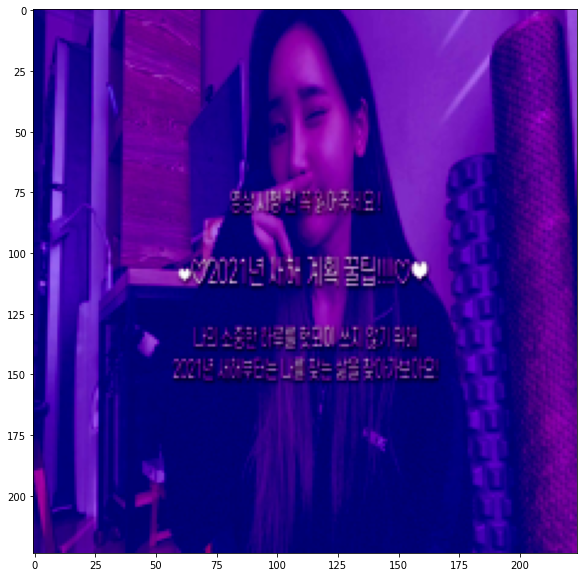

In [290]:
# plt.figure(figsize=(10, 10))
# plt.imshow(features[0].numpy().transpose(1, 2, 0)[:, :, ::-1])

In [22]:
model = SummaryModel()
model.to('cuda')
model.eval()

SummaryModel(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_featu

In [23]:
PATH = 'summary.ckpt'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [296]:
# features = features.to('cuda')
# print(features.shape)
# y_pred = []
# y_features=[]
# for frame in tqdm(features):
# #     print(frame.unsqueeze(0).shape)
#     y_p, y_f = model(frame.unsqueeze(0))
#     y_p = torch.sigmoid(y_p)
#     y_pred.append(y_p.cpu().detach().numpy().squeeze())
#     y_features.append(y_f.cpu().detach().numpy().squeeze())

# y_pred = np.array(y_pred)
# y_features= np.array(y_features) # extract features


torch.Size([633, 3, 224, 224])


100%|██████████| 633/633 [00:07<00:00, 85.39it/s]


In [297]:
# y_features.shape

(633, 768)

# evalutaion

## Load video data

In [24]:
import os

In [25]:
args = argparse.Namespace(
    videos = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Video_data/VS_유튜브_01",
    data_directory =  "/workspace/EmotionShortForm/data_AIHub/2.Validation/Labeling_data/VL_youtube",
    video_features_file = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Video_data/VS_유튜브_01.h5"
)

val_label_path = "/workspace/EmotionShortForm/data_AIHub/2.Validation/Labeling_data/VL_youtube"

## Inference

In [26]:
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

d = SummaryDataset(args.videos, args.data_directory, args.video_features_file)
dl = DataLoader(d, batch_size=1)

y_true=[]
y_pred=[]

for video_name, inputs, labels in tqdm_notebook(dl,total=len(dl), desc='Processing dataset' ):
    with torch.no_grad():
        model.eval()
        y_pred_list = []
        print(f'video_name: {video_name}, inputs.shape: {inputs.shape}, labels.shape: {labels.shape}')
        for f in tqdm(inputs.squeeze(0)):
            y_p, y_f = model(f.cuda().unsqueeze(0))
            y_p = torch.sigmoid(y_p)
            y_pred_list.append(y_p.cpu().detach().numpy().squeeze())    
        y_true.append(labels.cpu().detach().numpy().squeeze())
        y_pred.append(np.array(y_pred_list))    

y_true = np.array(y_true)
y_pred = np.array(y_pred)

Processing dataset:   0%|          | 0/31 [00:00<?, ?it/s]

video_name: ('유튜브_여행_7640',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 84.94it/s] 


video_name: ('유튜브_여행_7640',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.88it/s]


video_name: ('유튜브_여행_7640',), inputs.shape: torch.Size([1, 54, 3, 224, 224]), labels.shape: torch.Size([1, 54])



100%|██████████| 54/54 [00:00<00:00, 109.49it/s]


video_name: ('유튜브_스포츠_4174',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.87it/s]


video_name: ('유튜브_스포츠_4174',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.71it/s]


video_name: ('유튜브_스포츠_4174',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.50it/s]


video_name: ('유튜브_스포츠_4174',), inputs.shape: torch.Size([1, 86, 3, 224, 224]), labels.shape: torch.Size([1, 86])



100%|██████████| 86/86 [00:00<00:00, 109.71it/s]


video_name: ('유튜브_기타_19843',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 108.79it/s]


video_name: ('유튜브_기타_19843',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.89it/s]


video_name: ('유튜브_기타_19843',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.69it/s]


video_name: ('유튜브_기타_19843',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.80it/s]


video_name: ('유튜브_기타_19843',), inputs.shape: torch.Size([1, 43, 3, 224, 224]), labels.shape: torch.Size([1, 43])



100%|██████████| 43/43 [00:00<00:00, 108.39it/s]


video_name: ('유튜브_일상_10479',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 111.54it/s]


video_name: ('유튜브_일상_10479',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.69it/s]


video_name: ('유튜브_일상_10479',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.51it/s]


video_name: ('유튜브_일상_10479',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.39it/s]


video_name: ('유튜브_일상_10479',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.42it/s]


video_name: ('유튜브_일상_10479',), inputs.shape: torch.Size([1, 65, 3, 224, 224]), labels.shape: torch.Size([1, 65])



100%|██████████| 65/65 [00:00<00:00, 108.73it/s]


video_name: ('유튜브_스타일링및뷰티_14630',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 111.17it/s]


video_name: ('유튜브_스타일링및뷰티_14630',), inputs.shape: torch.Size([1, 208, 3, 224, 224]), labels.shape: torch.Size([1, 208])



100%|██████████| 208/208 [00:01<00:00, 110.43it/s]


video_name: ('유튜브_자동차_0094',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.64it/s]


video_name: ('유튜브_자동차_0094',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.10it/s]


video_name: ('유튜브_자동차_0094',), inputs.shape: torch.Size([1, 195, 3, 224, 224]), labels.shape: torch.Size([1, 195])



100%|██████████| 195/195 [00:01<00:00, 110.44it/s]


video_name: ('유튜브_반려동물및동물_2153',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 108.99it/s]


video_name: ('유튜브_반려동물및동물_2153',), inputs.shape: torch.Size([1, 232, 3, 224, 224]), labels.shape: torch.Size([1, 232])



100%|██████████| 232/232 [00:02<00:00, 110.46it/s]


video_name: ('유튜브_음식_17341',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.28it/s]


video_name: ('유튜브_음식_17341',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 111.16it/s]


video_name: ('유튜브_음식_17341',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 111.02it/s]


video_name: ('유튜브_음식_17341',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.52it/s]


video_name: ('유튜브_음식_17341',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 110.41it/s]


video_name: ('유튜브_음식_17341',), inputs.shape: torch.Size([1, 67, 3, 224, 224]), labels.shape: torch.Size([1, 67])



100%|██████████| 67/67 [00:00<00:00, 110.02it/s]


In [27]:
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

In [28]:
THRES = 0.4

# calculate scores
f1 = f1_score(y_true, np.where(y_pred > THRES, 1, 0), average='binary')
acc = accuracy_score(y_true, np.where(y_pred > THRES, 1, 0))
prec = precision_score(y_true, np.where(y_pred > THRES, 1, 0))
rec = recall_score(y_true, np.where(y_pred > THRES, 1, 0))

print("F1 Score: ", f1)
print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)

F1 Score:  0.12783121315544524
Accuracy:  0.5804477611940299
Precision:  0.43829787234042555
Recall:  0.07482746095168907


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined a

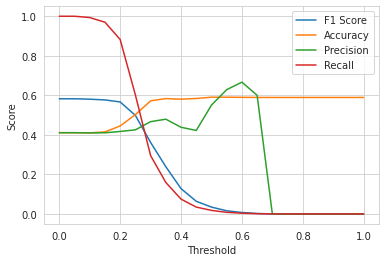

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# initialize lists for storing results
f1_scores = []
acc_scores = []
prec_scores = []
rec_scores = []

# vary threshold and calculate scores
for THRES in np.arange(0, 1.05, 0.05):
    # calculate scores
    f1 = f1_score(y_true, np.where(y_pred > THRES, 1, 0), average='binary')
    acc = accuracy_score(y_true, np.where(y_pred > THRES, 1, 0))
    prec = precision_score(y_true, np.where(y_pred > THRES, 1, 0))
    rec = recall_score(y_true, np.where(y_pred > THRES, 1, 0))
    
    # store scores in lists
    f1_scores.append(f1)
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)

# plot results
sns.set_style("whitegrid")
plt.plot(np.arange(0, 1.05, 0.05), f1_scores, label='F1 Score')
plt.plot(np.arange(0, 1.05, 0.05), acc_scores, label='Accuracy')
plt.plot(np.arange(0, 1.05, 0.05), prec_scores, label='Precision')
plt.plot(np.arange(0, 1.05, 0.05), rec_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()


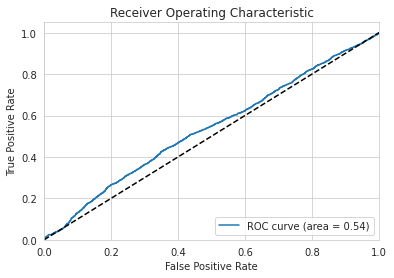

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# calculate fpr and tpr for different thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# calculate AUC
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [300]:
from tqdm.notebook import tqdm_notebook

d = SummaryDataset(args.videos, args.data_directory, args.video_features_file)
dl = DataLoader(d, batch_size=1)

vit_features = []
y_pred=[]

for video_name, inputs, labels in tqdm_notebook(dl,total=len(dl), desc='Processing dataset' ):
    with torch.no_grad():
        model.eval()
        y_pred_list = []
        vit_features_list=[]
        print(f'video_name: {video_name}, inputs.shape: {inputs.shape}, labels.shape: {labels.shape}')
        for f in tqdm(inputs.squeeze(0)):
#             print(f.unsqueeze(0).shape)
        #     print(frame.unsqueeze(0).shape)
            y_p, y_f = model(f.cuda().unsqueeze(0))
#            print(y_f.shape)
#             print(y_f.cpu().detach().numpy().shape)
            y_p = torch.sigmoid(y_p)
            y_pred_list.append(y_p.cpu().detach().numpy().squeeze())    
            vit_features_list.append(y_f.cpu().detach().numpy().squeeze())
        y_pred.append(np.array(y_pred_list))    
        vit_features.append(np.array(vit_features_list)) 
y_pred = np.array(y_pred)
vit_features= np.array(vit_features) # extract features

Processing dataset:   0%|          | 0/556 [00:00<?, ?it/s]

video_name: ('유튜브_기타_24002',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.81it/s]


video_name: ('유튜브_기타_24002',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.37it/s] 


video_name: ('유튜브_기타_24002',), inputs.shape: torch.Size([1, 202, 3, 224, 224]), labels.shape: torch.Size([1, 202])



100%|██████████| 202/202 [00:02<00:00, 100.16it/s][A


video_name: ('유튜브_기타_20532',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.48it/s]


video_name: ('유튜브_기타_20532',), inputs.shape: torch.Size([1, 136, 3, 224, 224]), labels.shape: torch.Size([1, 136])



100%|██████████| 136/136 [00:01<00:00, 100.92it/s]


video_name: ('유튜브_스타일링및뷰티_15723',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.25it/s] 


video_name: ('유튜브_스타일링및뷰티_15723',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.03it/s]


video_name: ('유튜브_스타일링및뷰티_15723',), inputs.shape: torch.Size([1, 125, 3, 224, 224]), labels.shape: torch.Size([1, 125])



100%|██████████| 125/125 [00:01<00:00, 100.12it/s]


video_name: ('유튜브_일상_13257',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.70it/s] 


video_name: ('유튜브_일상_13257',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.95it/s] 


video_name: ('유튜브_일상_13257',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.13it/s]


video_name: ('유튜브_일상_13257',), inputs.shape: torch.Size([1, 186, 3, 224, 224]), labels.shape: torch.Size([1, 186])



100%|██████████| 186/186 [00:01<00:00, 99.34it/s]


video_name: ('유튜브_음식_18221',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.49it/s]


video_name: ('유튜브_음식_18221',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 94.52it/s]


video_name: ('유튜브_음식_18221',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 94.88it/s]


video_name: ('유튜브_음식_18221',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 94.47it/s]


video_name: ('유튜브_음식_18221',), inputs.shape: torch.Size([1, 230, 3, 224, 224]), labels.shape: torch.Size([1, 230])



100%|██████████| 230/230 [00:02<00:00, 94.63it/s]


video_name: ('유튜브_스포츠_6188',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 94.61it/s]


video_name: ('유튜브_스포츠_6188',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 94.97it/s]


video_name: ('유튜브_스포츠_6188',), inputs.shape: torch.Size([1, 119, 3, 224, 224]), labels.shape: torch.Size([1, 119])



100%|██████████| 119/119 [00:01<00:00, 96.14it/s]


video_name: ('유튜브_자동차_1801',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 94.76it/s]


video_name: ('유튜브_자동차_1801',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 94.64it/s]


video_name: ('유튜브_자동차_1801',), inputs.shape: torch.Size([1, 134, 3, 224, 224]), labels.shape: torch.Size([1, 134])



100%|██████████| 134/134 [00:01<00:00, 96.34it/s]


video_name: ('유튜브_음식_18210',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 94.97it/s]


video_name: ('유튜브_음식_18210',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 87.37it/s]


video_name: ('유튜브_음식_18210',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 80.94it/s]


video_name: ('유튜브_음식_18210',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 94.83it/s]


video_name: ('유튜브_음식_18210',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.76it/s]


video_name: ('유튜브_음식_18210',), inputs.shape: torch.Size([1, 154, 3, 224, 224]), labels.shape: torch.Size([1, 154])



100%|██████████| 154/154 [00:01<00:00, 97.64it/s]


video_name: ('유튜브_음식_18933',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.31it/s]


video_name: ('유튜브_음식_18933',), inputs.shape: torch.Size([1, 104, 3, 224, 224]), labels.shape: torch.Size([1, 104])



100%|██████████| 104/104 [00:01<00:00, 97.86it/s]


video_name: ('유튜브_기타_22897',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.80it/s]


video_name: ('유튜브_기타_22897',), inputs.shape: torch.Size([1, 53, 3, 224, 224]), labels.shape: torch.Size([1, 53])



100%|██████████| 53/53 [00:00<00:00, 101.65it/s]


video_name: ('유튜브_일상_11022',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.29it/s] 


video_name: ('유튜브_일상_11022',), inputs.shape: torch.Size([1, 205, 3, 224, 224]), labels.shape: torch.Size([1, 205])



100%|██████████| 205/205 [00:02<00:00, 98.75it/s]


video_name: ('유튜브_스포츠_6343',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.61it/s]


video_name: ('유튜브_스포츠_6343',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 100.67it/s]


video_name: ('유튜브_스포츠_6343',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 100.91it/s]


video_name: ('유튜브_스포츠_6343',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.91it/s]


video_name: ('유튜브_스포츠_6343',), inputs.shape: torch.Size([1, 7, 3, 224, 224]), labels.shape: torch.Size([1, 7])



100%|██████████| 7/7 [00:00<00:00, 92.21it/s]


video_name: ('유튜브_스포츠_4643',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.77it/s]


video_name: ('유튜브_스포츠_4643',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.97it/s]


video_name: ('유튜브_스포츠_4643',), inputs.shape: torch.Size([1, 162, 3, 224, 224]), labels.shape: torch.Size([1, 162])



100%|██████████| 162/162 [00:01<00:00, 99.03it/s]


video_name: ('유튜브_반려동물및동물_4056',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.85it/s]


video_name: ('유튜브_반려동물및동물_4056',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.65it/s]


video_name: ('유튜브_반려동물및동물_4056',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.56it/s]


video_name: ('유튜브_반려동물및동물_4056',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.00it/s]


video_name: ('유튜브_반려동물및동물_4056',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.77it/s]


video_name: ('유튜브_반려동물및동물_4056',), inputs.shape: torch.Size([1, 1, 3, 224, 224]), labels.shape: torch.Size([1, 1])



100%|██████████| 1/1 [00:00<00:00, 53.03it/s]


video_name: ('유튜브_기타_20630',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.08it/s]


video_name: ('유튜브_기타_20630',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.32it/s] 


video_name: ('유튜브_기타_20630',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.70it/s] 


video_name: ('유튜브_기타_20630',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.76it/s] 


video_name: ('유튜브_기타_20630',), inputs.shape: torch.Size([1, 116, 3, 224, 224]), labels.shape: torch.Size([1, 116])



100%|██████████| 116/116 [00:01<00:00, 100.40it/s]


video_name: ('유튜브_기타_21891',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.38it/s]


video_name: ('유튜브_기타_21891',), inputs.shape: torch.Size([1, 67, 3, 224, 224]), labels.shape: torch.Size([1, 67])



100%|██████████| 67/67 [00:00<00:00, 96.44it/s]


video_name: ('유튜브_기타_21582',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.73it/s]


video_name: ('유튜브_기타_21582',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.82it/s]


video_name: ('유튜브_기타_21582',), inputs.shape: torch.Size([1, 235, 3, 224, 224]), labels.shape: torch.Size([1, 235])



100%|██████████| 235/235 [00:02<00:00, 97.67it/s]


video_name: ('유튜브_일상_13227',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.42it/s]


video_name: ('유튜브_일상_13227',), inputs.shape: torch.Size([1, 223, 3, 224, 224]), labels.shape: torch.Size([1, 224])



100%|██████████| 223/223 [00:02<00:00, 98.63it/s] 


video_name: ('유튜브_여행_9144',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 101.00it/s]


video_name: ('유튜브_여행_9144',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 101.19it/s]


video_name: ('유튜브_여행_9144',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 101.30it/s]


video_name: ('유튜브_여행_9144',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.17it/s]


video_name: ('유튜브_여행_9144',), inputs.shape: torch.Size([1, 192, 3, 224, 224]), labels.shape: torch.Size([1, 192])



100%|██████████| 192/192 [00:01<00:00, 99.89it/s] 


video_name: ('유튜브_스타일링및뷰티_16648',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 100.81it/s]


video_name: ('유튜브_스타일링및뷰티_16648',), inputs.shape: torch.Size([1, 231, 3, 224, 224]), labels.shape: torch.Size([1, 231])



100%|██████████| 231/231 [00:02<00:00, 99.56it/s] 


video_name: ('유튜브_반려동물및동물_4029',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.50it/s] 


video_name: ('유튜브_반려동물및동물_4029',), inputs.shape: torch.Size([1, 209, 3, 224, 224]), labels.shape: torch.Size([1, 209])



100%|██████████| 209/209 [00:02<00:00, 100.00it/s]


video_name: ('유튜브_스포츠_5781',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.13it/s] 


video_name: ('유튜브_스포츠_5781',), inputs.shape: torch.Size([1, 52, 3, 224, 224]), labels.shape: torch.Size([1, 52])



100%|██████████| 52/52 [00:00<00:00, 100.85it/s]


video_name: ('유튜브_일상_11555',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.97it/s]


video_name: ('유튜브_일상_11555',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.74it/s]


video_name: ('유튜브_일상_11555',), inputs.shape: torch.Size([1, 101, 3, 224, 224]), labels.shape: torch.Size([1, 101])



100%|██████████| 101/101 [00:01<00:00, 99.83it/s]


video_name: ('유튜브_스포츠_7528',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.52it/s]


video_name: ('유튜브_스포츠_7528',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.06it/s]


video_name: ('유튜브_스포츠_7528',), inputs.shape: torch.Size([1, 64, 3, 224, 224]), labels.shape: torch.Size([1, 64])



100%|██████████| 64/64 [00:00<00:00, 98.09it/s]


video_name: ('유튜브_자동차_1653',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.13it/s]


video_name: ('유튜브_자동차_1653',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.96it/s]


video_name: ('유튜브_자동차_1653',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.33it/s]


video_name: ('유튜브_자동차_1653',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.35it/s] 


video_name: ('유튜브_자동차_1653',), inputs.shape: torch.Size([1, 201, 3, 224, 224]), labels.shape: torch.Size([1, 201])



100%|██████████| 201/201 [00:02<00:00, 98.23it/s]


video_name: ('유튜브_기타_22243',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.66it/s] 


video_name: ('유튜브_기타_22243',), inputs.shape: torch.Size([1, 249, 3, 224, 224]), labels.shape: torch.Size([1, 249])



100%|██████████| 249/249 [00:02<00:00, 98.11it/s]


video_name: ('유튜브_여행_8379',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.40it/s]


video_name: ('유튜브_여행_8379',), inputs.shape: torch.Size([1, 233, 3, 224, 224]), labels.shape: torch.Size([1, 233])



100%|██████████| 233/233 [00:02<00:00, 98.24it/s]


video_name: ('유튜브_스포츠_4543',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.99it/s] 


video_name: ('유튜브_스포츠_4543',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.82it/s] 


video_name: ('유튜브_스포츠_4543',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.14it/s] 


video_name: ('유튜브_스포츠_4543',), inputs.shape: torch.Size([1, 84, 3, 224, 224]), labels.shape: torch.Size([1, 85])



100%|██████████| 84/84 [00:00<00:00, 100.88it/s]


video_name: ('유튜브_일상_14339',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.05it/s] 


video_name: ('유튜브_일상_14339',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.73it/s]


video_name: ('유튜브_일상_14339',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.80it/s] 


video_name: ('유튜브_일상_14339',), inputs.shape: torch.Size([1, 84, 3, 224, 224]), labels.shape: torch.Size([1, 84])



100%|██████████| 84/84 [00:00<00:00, 100.60it/s]


video_name: ('유튜브_스포츠_6348',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.19it/s]


video_name: ('유튜브_스포츠_6348',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.81it/s]


video_name: ('유튜브_스포츠_6348',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.88it/s]


video_name: ('유튜브_스포츠_6348',), inputs.shape: torch.Size([1, 229, 3, 224, 224]), labels.shape: torch.Size([1, 229])



100%|██████████| 229/229 [00:02<00:00, 97.18it/s]


video_name: ('유튜브_음식_18897',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.75it/s]


video_name: ('유튜브_음식_18897',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.30it/s] 


video_name: ('유튜브_음식_18897',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.49it/s] 


video_name: ('유튜브_음식_18897',), inputs.shape: torch.Size([1, 120, 3, 224, 224]), labels.shape: torch.Size([1, 120])



100%|██████████| 120/120 [00:01<00:00, 100.23it/s]


video_name: ('유튜브_반려동물및동물_3818',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.20it/s] 


video_name: ('유튜브_반려동물및동물_3818',), inputs.shape: torch.Size([1, 169, 3, 224, 224]), labels.shape: torch.Size([1, 169])



100%|██████████| 169/169 [00:01<00:00, 98.94it/s]


video_name: ('유튜브_기타_21853',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.97it/s] 


video_name: ('유튜브_기타_21853',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.23it/s] 


video_name: ('유튜브_기타_21853',), inputs.shape: torch.Size([1, 108, 3, 224, 224]), labels.shape: torch.Size([1, 108])



100%|██████████| 108/108 [00:01<00:00, 100.02it/s][A


video_name: ('유튜브_스타일링및뷰티_16672',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 100.05it/s]


video_name: ('유튜브_스타일링및뷰티_16672',), inputs.shape: torch.Size([1, 88, 3, 224, 224]), labels.shape: torch.Size([1, 88])



100%|██████████| 88/88 [00:00<00:00, 99.87it/s] 


video_name: ('유튜브_음식_19141',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.36it/s] 


video_name: ('유튜브_음식_19141',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.60it/s]


video_name: ('유튜브_음식_19141',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.18it/s]


video_name: ('유튜브_음식_19141',), inputs.shape: torch.Size([1, 120, 3, 224, 224]), labels.shape: torch.Size([1, 120])



100%|██████████| 120/120 [00:01<00:00, 99.25it/s]


video_name: ('유튜브_자동차_0879',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.19it/s]


video_name: ('유튜브_자동차_0879',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.40it/s]


video_name: ('유튜브_자동차_0879',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.99it/s]


video_name: ('유튜브_자동차_0879',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.26it/s]


video_name: ('유튜브_자동차_0879',), inputs.shape: torch.Size([1, 168, 3, 224, 224]), labels.shape: torch.Size([1, 168])



100%|██████████| 168/168 [00:01<00:00, 99.26it/s]


video_name: ('유튜브_기타_23841',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.23it/s]


video_name: ('유튜브_기타_23841',), inputs.shape: torch.Size([1, 66, 3, 224, 224]), labels.shape: torch.Size([1, 66])



100%|██████████| 66/66 [00:00<00:00, 99.25it/s] 


video_name: ('유튜브_스타일링및뷰티_15187',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.07it/s]


video_name: ('유튜브_스타일링및뷰티_15187',), inputs.shape: torch.Size([1, 179, 3, 224, 224]), labels.shape: torch.Size([1, 179])



100%|██████████| 179/179 [00:01<00:00, 99.14it/s]


video_name: ('유튜브_일상_11325',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.07it/s]


video_name: ('유튜브_일상_11325',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.13it/s]


video_name: ('유튜브_일상_11325',), inputs.shape: torch.Size([1, 103, 3, 224, 224]), labels.shape: torch.Size([1, 103])



100%|██████████| 103/103 [00:01<00:00, 100.28it/s][A


video_name: ('유튜브_스포츠_5270',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.24it/s]


video_name: ('유튜브_스포츠_5270',), inputs.shape: torch.Size([1, 107, 3, 224, 224]), labels.shape: torch.Size([1, 107])



100%|██████████| 107/107 [00:01<00:00, 100.34it/s][A


video_name: ('유튜브_일상_13519',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.88it/s]


video_name: ('유튜브_일상_13519',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 100.13it/s]


video_name: ('유튜브_일상_13519',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.67it/s]


video_name: ('유튜브_일상_13519',), inputs.shape: torch.Size([1, 73, 3, 224, 224]), labels.shape: torch.Size([1, 73])



100%|██████████| 73/73 [00:00<00:00, 98.75it/s]


video_name: ('유튜브_일상_13554',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.64it/s]


video_name: ('유튜브_일상_13554',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.10it/s]


video_name: ('유튜브_일상_13554',), inputs.shape: torch.Size([1, 46, 3, 224, 224]), labels.shape: torch.Size([1, 46])



100%|██████████| 46/46 [00:00<00:00, 99.85it/s] 


video_name: ('유튜브_자동차_0320',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.90it/s]


video_name: ('유튜브_자동차_0320',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.73it/s]


video_name: ('유튜브_자동차_0320',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.28it/s]


video_name: ('유튜브_자동차_0320',), inputs.shape: torch.Size([1, 120, 3, 224, 224]), labels.shape: torch.Size([1, 120])



100%|██████████| 120/120 [00:01<00:00, 99.34it/s] 


video_name: ('유튜브_스포츠_4608',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.65it/s]


video_name: ('유튜브_스포츠_4608',), inputs.shape: torch.Size([1, 220, 3, 224, 224]), labels.shape: torch.Size([1, 220])



100%|██████████| 220/220 [00:02<00:00, 97.30it/s]


video_name: ('유튜브_기타_23677',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.55it/s]


video_name: ('유튜브_기타_23677',), inputs.shape: torch.Size([1, 178, 3, 224, 224]), labels.shape: torch.Size([1, 178])



100%|██████████| 178/178 [00:01<00:00, 97.90it/s]


video_name: ('유튜브_일상_14359',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.76it/s]


video_name: ('유튜브_일상_14359',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.05it/s]


video_name: ('유튜브_일상_14359',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.19it/s]


video_name: ('유튜브_일상_14359',), inputs.shape: torch.Size([1, 123, 3, 224, 224]), labels.shape: torch.Size([1, 123])



100%|██████████| 123/123 [00:01<00:00, 97.18it/s]


video_name: ('유튜브_반려동물및동물_3653',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.55it/s] 


video_name: ('유튜브_반려동물및동물_3653',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.90it/s]


video_name: ('유튜브_반려동물및동물_3653',), inputs.shape: torch.Size([1, 236, 3, 224, 224]), labels.shape: torch.Size([1, 236])



100%|██████████| 236/236 [00:02<00:00, 99.20it/s] 


video_name: ('유튜브_기타_22526',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.67it/s]


video_name: ('유튜브_기타_22526',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.19it/s]


video_name: ('유튜브_기타_22526',), inputs.shape: torch.Size([1, 196, 3, 224, 224]), labels.shape: torch.Size([1, 196])



100%|██████████| 196/196 [00:01<00:00, 100.11it/s]


video_name: ('유튜브_일상_12110',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.04it/s] 


video_name: ('유튜브_일상_12110',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.37it/s]


video_name: ('유튜브_일상_12110',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.13it/s]


video_name: ('유튜브_일상_12110',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.31it/s]


video_name: ('유튜브_일상_12110',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.97it/s]


video_name: ('유튜브_일상_12110',), inputs.shape: torch.Size([1, 124, 3, 224, 224]), labels.shape: torch.Size([1, 124])



100%|██████████| 124/124 [00:01<00:00, 99.52it/s] 


video_name: ('유튜브_기타_22420',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 94.05it/s]


video_name: ('유튜브_기타_22420',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.91it/s]


video_name: ('유튜브_기타_22420',), inputs.shape: torch.Size([1, 195, 3, 224, 224]), labels.shape: torch.Size([1, 195])



100%|██████████| 195/195 [00:01<00:00, 98.51it/s]


video_name: ('유튜브_반려동물및동물_4394',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.46it/s]


video_name: ('유튜브_반려동물및동물_4394',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.42it/s]


video_name: ('유튜브_반려동물및동물_4394',), inputs.shape: torch.Size([1, 111, 3, 224, 224]), labels.shape: torch.Size([1, 106])



100%|██████████| 111/111 [00:01<00:00, 98.12it/s]


video_name: ('유튜브_스포츠_7094',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.98it/s]


video_name: ('유튜브_스포츠_7094',), inputs.shape: torch.Size([1, 54, 3, 224, 224]), labels.shape: torch.Size([1, 54])



100%|██████████| 54/54 [00:00<00:00, 97.79it/s]


video_name: ('유튜브_기타_23915',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.47it/s]


video_name: ('유튜브_기타_23915',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.57it/s]


video_name: ('유튜브_기타_23915',), inputs.shape: torch.Size([1, 97, 3, 224, 224]), labels.shape: torch.Size([1, 97])



100%|██████████| 97/97 [00:00<00:00, 98.55it/s]


video_name: ('유튜브_스타일링및뷰티_15096',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.14it/s]


video_name: ('유튜브_스타일링및뷰티_15096',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 91.04it/s]


video_name: ('유튜브_스타일링및뷰티_15096',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 91.18it/s] 


video_name: ('유튜브_스타일링및뷰티_15096',), inputs.shape: torch.Size([1, 43, 3, 224, 224]), labels.shape: torch.Size([1, 43])



100%|██████████| 43/43 [00:00<00:00, 97.16it/s]


video_name: ('유튜브_여행_9173',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.46it/s] 


video_name: ('유튜브_여행_9173',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.34it/s] 


video_name: ('유튜브_여행_9173',), inputs.shape: torch.Size([1, 243, 3, 224, 224]), labels.shape: torch.Size([1, 243])



100%|██████████| 243/243 [00:02<00:00, 96.48it/s]


video_name: ('유튜브_음식_19596',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.01it/s]


video_name: ('유튜브_음식_19596',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 101.59it/s]


video_name: ('유튜브_음식_19596',), inputs.shape: torch.Size([1, 6, 3, 224, 224]), labels.shape: torch.Size([1, 6])



100%|██████████| 6/6 [00:00<00:00, 91.46it/s]


video_name: ('유튜브_스포츠_4599',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 101.43it/s]


video_name: ('유튜브_스포츠_4599',), inputs.shape: torch.Size([1, 78, 3, 224, 224]), labels.shape: torch.Size([1, 78])



100%|██████████| 78/78 [00:00<00:00, 100.63it/s]


video_name: ('유튜브_스타일링및뷰티_17181',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.73it/s] 


video_name: ('유튜브_스타일링및뷰티_17181',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.64it/s] 


video_name: ('유튜브_스타일링및뷰티_17181',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.04it/s]


video_name: ('유튜브_스타일링및뷰티_17181',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.83it/s] 


video_name: ('유튜브_스타일링및뷰티_17181',), inputs.shape: torch.Size([1, 49, 3, 224, 224]), labels.shape: torch.Size([1, 49])



100%|██████████| 49/49 [00:00<00:00, 97.40it/s]


video_name: ('유튜브_스포츠_6702',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.23it/s]


video_name: ('유튜브_스포츠_6702',), inputs.shape: torch.Size([1, 109, 3, 224, 224]), labels.shape: torch.Size([1, 109])



100%|██████████| 109/109 [00:01<00:00, 99.71it/s] 


video_name: ('유튜브_여행_9888',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.38it/s]


video_name: ('유튜브_여행_9888',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.34it/s]


video_name: ('유튜브_여행_9888',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.94it/s] 


video_name: ('유튜브_여행_9888',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 100.12it/s]


video_name: ('유튜브_여행_9888',), inputs.shape: torch.Size([1, 40, 3, 224, 224]), labels.shape: torch.Size([1, 40])



100%|██████████| 40/40 [00:00<00:00, 99.95it/s] 


video_name: ('유튜브_여행_9467',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.91it/s] 


video_name: ('유튜브_여행_9467',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.96it/s]


video_name: ('유튜브_여행_9467',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.32it/s] 


video_name: ('유튜브_여행_9467',), inputs.shape: torch.Size([1, 145, 3, 224, 224]), labels.shape: torch.Size([1, 145])



100%|██████████| 145/145 [00:01<00:00, 101.58it/s]


video_name: ('유튜브_여행_9472',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.68it/s] 


video_name: ('유튜브_여행_9472',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.09it/s] 


video_name: ('유튜브_여행_9472',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.47it/s] 


video_name: ('유튜브_여행_9472',), inputs.shape: torch.Size([1, 102, 3, 224, 224]), labels.shape: torch.Size([1, 102])



100%|██████████| 102/102 [00:01<00:00, 100.82it/s][A


video_name: ('유튜브_스포츠_7630',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.80it/s] 


video_name: ('유튜브_스포츠_7630',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.91it/s]


video_name: ('유튜브_스포츠_7630',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.92it/s] 


video_name: ('유튜브_스포츠_7630',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.35it/s] 


video_name: ('유튜브_스포츠_7630',), inputs.shape: torch.Size([1, 129, 3, 224, 224]), labels.shape: torch.Size([1, 129])



100%|██████████| 129/129 [00:01<00:00, 99.99it/s] 


video_name: ('유튜브_음식_18020',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.65it/s] 


video_name: ('유튜브_음식_18020',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.56it/s] 


video_name: ('유튜브_음식_18020',), inputs.shape: torch.Size([1, 23, 3, 224, 224]), labels.shape: torch.Size([1, 23])



100%|██████████| 23/23 [00:00<00:00, 97.16it/s]


video_name: ('유튜브_여행_8918',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.96it/s]


video_name: ('유튜브_여행_8918',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.01it/s] 


video_name: ('유튜브_여행_8918',), inputs.shape: torch.Size([1, 101, 3, 224, 224]), labels.shape: torch.Size([1, 101])



100%|██████████| 101/101 [00:01<00:00, 99.95it/s]


video_name: ('유튜브_스포츠_5137',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.29it/s]


video_name: ('유튜브_스포츠_5137',), inputs.shape: torch.Size([1, 121, 3, 224, 224]), labels.shape: torch.Size([1, 121])



100%|██████████| 121/121 [00:01<00:00, 99.73it/s] 


video_name: ('유튜브_여행_8099',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.93it/s] 


video_name: ('유튜브_여행_8099',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.87it/s] 


video_name: ('유튜브_여행_8099',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.34it/s]


video_name: ('유튜브_여행_8099',), inputs.shape: torch.Size([1, 152, 3, 224, 224]), labels.shape: torch.Size([1, 152])



100%|██████████| 152/152 [00:01<00:00, 98.75it/s]


video_name: ('유튜브_일상_13513',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.10it/s]


video_name: ('유튜브_일상_13513',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.17it/s] 


video_name: ('유튜브_일상_13513',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.87it/s] 


video_name: ('유튜브_일상_13513',), inputs.shape: torch.Size([1, 121, 3, 224, 224]), labels.shape: torch.Size([1, 121])



100%|██████████| 121/121 [00:01<00:00, 99.67it/s] 


video_name: ('유튜브_스포츠_4909',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.59it/s] 


video_name: ('유튜브_스포츠_4909',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.25it/s]


video_name: ('유튜브_스포츠_4909',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.06it/s] 


video_name: ('유튜브_스포츠_4909',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.31it/s] 


video_name: ('유튜브_스포츠_4909',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.07it/s] 


video_name: ('유튜브_스포츠_4909',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.61it/s] 


video_name: ('유튜브_스포츠_4909',), inputs.shape: torch.Size([1, 230, 3, 224, 224]), labels.shape: torch.Size([1, 230])



100%|██████████| 230/230 [00:02<00:00, 98.04it/s]


video_name: ('유튜브_기타_21240',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.39it/s]


video_name: ('유튜브_기타_21240',), inputs.shape: torch.Size([1, 134, 3, 224, 224]), labels.shape: torch.Size([1, 134])



100%|██████████| 134/134 [00:01<00:00, 97.83it/s]


video_name: ('유튜브_반려동물및동물_3516',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.94it/s]


video_name: ('유튜브_반려동물및동물_3516',), inputs.shape: torch.Size([1, 71, 3, 224, 224]), labels.shape: torch.Size([1, 71])



100%|██████████| 71/71 [00:00<00:00, 100.88it/s]


video_name: ('유튜브_반려동물및동물_4347',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.54it/s]


video_name: ('유튜브_반려동물및동물_4347',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 100.11it/s]


video_name: ('유튜브_반려동물및동물_4347',), inputs.shape: torch.Size([1, 181, 3, 224, 224]), labels.shape: torch.Size([1, 177])



100%|██████████| 181/181 [00:01<00:00, 98.08it/s]


video_name: ('유튜브_스포츠_6403',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.93it/s]


video_name: ('유튜브_스포츠_6403',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.42it/s] 


video_name: ('유튜브_스포츠_6403',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.53it/s] 


video_name: ('유튜브_스포츠_6403',), inputs.shape: torch.Size([1, 56, 3, 224, 224]), labels.shape: torch.Size([1, 56])



100%|██████████| 56/56 [00:00<00:00, 100.06it/s]


video_name: ('유튜브_기타_21043',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.25it/s]


video_name: ('유튜브_기타_21043',), inputs.shape: torch.Size([1, 107, 3, 224, 224]), labels.shape: torch.Size([1, 107])



100%|██████████| 107/107 [00:01<00:00, 100.84it/s][A


video_name: ('유튜브_스포츠_7817',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.92it/s]


video_name: ('유튜브_스포츠_7817',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.88it/s] 


video_name: ('유튜브_스포츠_7817',), inputs.shape: torch.Size([1, 109, 3, 224, 224]), labels.shape: torch.Size([1, 109])



100%|██████████| 109/109 [00:01<00:00, 100.09it/s]


video_name: ('유튜브_음식_17395',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.55it/s] 


video_name: ('유튜브_음식_17395',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.02it/s]


video_name: ('유튜브_음식_17395',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.70it/s] 


video_name: ('유튜브_음식_17395',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.77it/s]


video_name: ('유튜브_음식_17395',), inputs.shape: torch.Size([1, 77, 3, 224, 224]), labels.shape: torch.Size([1, 77])



100%|██████████| 77/77 [00:00<00:00, 99.20it/s]


video_name: ('유튜브_일상_13211',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.37it/s] 


video_name: ('유튜브_일상_13211',), inputs.shape: torch.Size([1, 201, 3, 224, 224]), labels.shape: torch.Size([1, 201])



100%|██████████| 201/201 [00:02<00:00, 98.79it/s]


video_name: ('유튜브_기타_23766',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.22it/s]


video_name: ('유튜브_기타_23766',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.73it/s] 


video_name: ('유튜브_기타_23766',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.28it/s]


video_name: ('유튜브_기타_23766',), inputs.shape: torch.Size([1, 240, 3, 224, 224]), labels.shape: torch.Size([1, 240])



100%|██████████| 240/240 [00:02<00:00, 97.51it/s]


video_name: ('유튜브_기타_21352',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.29it/s]


video_name: ('유튜브_기타_21352',), inputs.shape: torch.Size([1, 179, 3, 224, 224]), labels.shape: torch.Size([1, 179])



100%|██████████| 179/179 [00:01<00:00, 100.59it/s]


video_name: ('유튜브_기타_22680',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.40it/s] 


video_name: ('유튜브_기타_22680',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.77it/s] 


video_name: ('유튜브_기타_22680',), inputs.shape: torch.Size([1, 105, 3, 224, 224]), labels.shape: torch.Size([1, 105])



100%|██████████| 105/105 [00:01<00:00, 100.56it/s][A


video_name: ('유튜브_일상_13414',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.75it/s]


video_name: ('유튜브_일상_13414',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.85it/s] 


video_name: ('유튜브_일상_13414',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.59it/s] 


video_name: ('유튜브_일상_13414',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.43it/s] 


video_name: ('유튜브_일상_13414',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.75it/s]


video_name: ('유튜브_일상_13414',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.60it/s]


video_name: ('유튜브_일상_13414',), inputs.shape: torch.Size([1, 151, 3, 224, 224]), labels.shape: torch.Size([1, 151])



100%|██████████| 151/151 [00:01<00:00, 97.56it/s]


video_name: ('유튜브_음식_19574',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.30it/s] 


video_name: ('유튜브_음식_19574',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.81it/s] 


video_name: ('유튜브_음식_19574',), inputs.shape: torch.Size([1, 57, 3, 224, 224]), labels.shape: torch.Size([1, 57])



100%|██████████| 57/57 [00:00<00:00, 98.40it/s]


video_name: ('유튜브_일상_10679',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.00it/s] 


video_name: ('유튜브_일상_10679',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.80it/s] 


video_name: ('유튜브_일상_10679',), inputs.shape: torch.Size([1, 158, 3, 224, 224]), labels.shape: torch.Size([1, 158])



100%|██████████| 158/158 [00:01<00:00, 100.13it/s]


video_name: ('유튜브_스포츠_6869',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.87it/s]


video_name: ('유튜브_스포츠_6869',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.05it/s] 


video_name: ('유튜브_스포츠_6869',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.87it/s] 


video_name: ('유튜브_스포츠_6869',), inputs.shape: torch.Size([1, 128, 3, 224, 224]), labels.shape: torch.Size([1, 128])



100%|██████████| 128/128 [00:01<00:00, 100.21it/s]


video_name: ('유튜브_스타일링및뷰티_15498',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.92it/s] 


video_name: ('유튜브_스타일링및뷰티_15498',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.88it/s]


video_name: ('유튜브_스타일링및뷰티_15498',), inputs.shape: torch.Size([1, 178, 3, 224, 224]), labels.shape: torch.Size([1, 178])



100%|██████████| 178/178 [00:01<00:00, 100.50it/s][A


video_name: ('유튜브_반려동물및동물_3670',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.51it/s] 


video_name: ('유튜브_반려동물및동물_3670',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.96it/s] 


video_name: ('유튜브_반려동물및동물_3670',), inputs.shape: torch.Size([1, 198, 3, 224, 224]), labels.shape: torch.Size([1, 198])



100%|██████████| 198/198 [00:01<00:00, 100.42it/s]


video_name: ('유튜브_음식_18372',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.15it/s] 


video_name: ('유튜브_음식_18372',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.21it/s]


video_name: ('유튜브_음식_18372',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.53it/s]


video_name: ('유튜브_음식_18372',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.33it/s]


video_name: ('유튜브_음식_18372',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.09it/s] 


video_name: ('유튜브_음식_18372',), inputs.shape: torch.Size([1, 19, 3, 224, 224]), labels.shape: torch.Size([1, 19])



100%|██████████| 19/19 [00:00<00:00, 97.30it/s]


video_name: ('유튜브_기타_22186',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.13it/s] 


video_name: ('유튜브_기타_22186',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.85it/s]


video_name: ('유튜브_기타_22186',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.55it/s]


video_name: ('유튜브_기타_22186',), inputs.shape: torch.Size([1, 44, 3, 224, 224]), labels.shape: torch.Size([1, 44])



100%|██████████| 44/44 [00:00<00:00, 98.59it/s] 


video_name: ('유튜브_음식_19417',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.85it/s]


video_name: ('유튜브_음식_19417',), inputs.shape: torch.Size([1, 238, 3, 224, 224]), labels.shape: torch.Size([1, 238])



100%|██████████| 238/238 [00:02<00:00, 97.75it/s]


video_name: ('유튜브_기타_21516',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.99it/s]


video_name: ('유튜브_기타_21516',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.85it/s]


video_name: ('유튜브_기타_21516',), inputs.shape: torch.Size([1, 133, 3, 224, 224]), labels.shape: torch.Size([1, 133])



100%|██████████| 133/133 [00:01<00:00, 98.36it/s] 


video_name: ('유튜브_기타_21387',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.75it/s] 


video_name: ('유튜브_기타_21387',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.63it/s] 


video_name: ('유튜브_기타_21387',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.53it/s]


video_name: ('유튜브_기타_21387',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.64it/s] 


video_name: ('유튜브_기타_21387',), inputs.shape: torch.Size([1, 22, 3, 224, 224]), labels.shape: torch.Size([1, 22])



100%|██████████| 22/22 [00:00<00:00, 96.42it/s]


video_name: ('유튜브_자동차_0795',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.44it/s] 


video_name: ('유튜브_자동차_0795',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.13it/s] 


video_name: ('유튜브_자동차_0795',), inputs.shape: torch.Size([1, 219, 3, 224, 224]), labels.shape: torch.Size([1, 219])



100%|██████████| 219/219 [00:02<00:00, 97.96it/s]


video_name: ('유튜브_반려동물및동물_2378',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.60it/s] 


video_name: ('유튜브_반려동물및동물_2378',), inputs.shape: torch.Size([1, 98, 3, 224, 224]), labels.shape: torch.Size([1, 98])



100%|██████████| 98/98 [00:01<00:00, 97.38it/s]


video_name: ('유튜브_스포츠_6089',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.09it/s] 


video_name: ('유튜브_스포츠_6089',), inputs.shape: torch.Size([1, 159, 3, 224, 224]), labels.shape: torch.Size([1, 159])



100%|██████████| 159/159 [00:01<00:00, 100.65it/s]


video_name: ('유튜브_기타_20017',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.42it/s] 


video_name: ('유튜브_기타_20017',), inputs.shape: torch.Size([1, 103, 3, 224, 224]), labels.shape: torch.Size([1, 103])



100%|██████████| 103/103 [00:01<00:00, 100.47it/s][A


video_name: ('유튜브_일상_13269',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.74it/s] 


video_name: ('유튜브_일상_13269',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.66it/s] 


video_name: ('유튜브_일상_13269',), inputs.shape: torch.Size([1, 247, 3, 224, 224]), labels.shape: torch.Size([1, 247])



100%|██████████| 247/247 [00:02<00:00, 98.05it/s]


video_name: ('유튜브_일상_13406',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.63it/s] 


video_name: ('유튜브_일상_13406',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.67it/s]


video_name: ('유튜브_일상_13406',), inputs.shape: torch.Size([1, 39, 3, 224, 224]), labels.shape: torch.Size([1, 39])



100%|██████████| 39/39 [00:00<00:00, 98.28it/s]


video_name: ('유튜브_기타_22670',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.72it/s] 


video_name: ('유튜브_기타_22670',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.94it/s]


video_name: ('유튜브_기타_22670',), inputs.shape: torch.Size([1, 189, 3, 224, 224]), labels.shape: torch.Size([1, 189])



100%|██████████| 189/189 [00:01<00:00, 99.74it/s]


video_name: ('유튜브_반려동물및동물_3220',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.97it/s]


video_name: ('유튜브_반려동물및동물_3220',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.09it/s] 


video_name: ('유튜브_반려동물및동물_3220',), inputs.shape: torch.Size([1, 64, 3, 224, 224]), labels.shape: torch.Size([1, 64])



100%|██████████| 64/64 [00:00<00:00, 100.24it/s]


video_name: ('유튜브_스타일링및뷰티_16915',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.43it/s]


video_name: ('유튜브_스타일링및뷰티_16915',), inputs.shape: torch.Size([1, 242, 3, 224, 224]), labels.shape: torch.Size([1, 242])



100%|██████████| 242/242 [00:02<00:00, 97.28it/s]


video_name: ('유튜브_스포츠_7692',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.84it/s]


video_name: ('유튜브_스포츠_7692',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.06it/s]


video_name: ('유튜브_스포츠_7692',), inputs.shape: torch.Size([1, 198, 3, 224, 224]), labels.shape: torch.Size([1, 198])



100%|██████████| 198/198 [00:02<00:00, 98.80it/s]


video_name: ('유튜브_일상_11396',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.58it/s]


video_name: ('유튜브_일상_11396',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.85it/s] 


video_name: ('유튜브_일상_11396',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.64it/s] 


video_name: ('유튜브_일상_11396',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.78it/s] 


video_name: ('유튜브_일상_11396',), inputs.shape: torch.Size([1, 66, 3, 224, 224]), labels.shape: torch.Size([1, 66])



100%|██████████| 66/66 [00:00<00:00, 100.02it/s]


video_name: ('유튜브_일상_11665',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.00it/s]


video_name: ('유튜브_일상_11665',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.77it/s] 


video_name: ('유튜브_일상_11665',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.66it/s]


video_name: ('유튜브_일상_11665',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.15it/s]


video_name: ('유튜브_일상_11665',), inputs.shape: torch.Size([1, 138, 3, 224, 224]), labels.shape: torch.Size([1, 138])



100%|██████████| 138/138 [00:01<00:00, 99.83it/s] 


video_name: ('유튜브_음식_18048',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.85it/s]


video_name: ('유튜브_음식_18048',), inputs.shape: torch.Size([1, 209, 3, 224, 224]), labels.shape: torch.Size([1, 209])



100%|██████████| 209/209 [00:02<00:00, 95.84it/s]


video_name: ('유튜브_일상_14017',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.33it/s]


video_name: ('유튜브_일상_14017',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.14it/s]


video_name: ('유튜브_일상_14017',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.39it/s]


video_name: ('유튜브_일상_14017',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.02it/s]


video_name: ('유튜브_일상_14017',), inputs.shape: torch.Size([1, 25, 3, 224, 224]), labels.shape: torch.Size([1, 25])



100%|██████████| 25/25 [00:00<00:00, 94.87it/s]


video_name: ('유튜브_기타_23589',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.21it/s]


video_name: ('유튜브_기타_23589',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 94.16it/s]


video_name: ('유튜브_기타_23589',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.16it/s]


video_name: ('유튜브_기타_23589',), inputs.shape: torch.Size([1, 177, 3, 224, 224]), labels.shape: torch.Size([1, 177])



100%|██████████| 177/177 [00:01<00:00, 96.48it/s]


video_name: ('유튜브_스포츠_5350',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 94.82it/s]


video_name: ('유튜브_스포츠_5350',), inputs.shape: torch.Size([1, 137, 3, 224, 224]), labels.shape: torch.Size([1, 137])



100%|██████████| 137/137 [00:01<00:00, 96.95it/s]


video_name: ('유튜브_스타일링및뷰티_16779',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 94.55it/s]


video_name: ('유튜브_스타일링및뷰티_16779',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.06it/s]


video_name: ('유튜브_스타일링및뷰티_16779',), inputs.shape: torch.Size([1, 236, 3, 224, 224]), labels.shape: torch.Size([1, 237])



100%|██████████| 236/236 [00:02<00:00, 98.51it/s] 


video_name: ('유튜브_반려동물및동물_4386',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.59it/s] 


video_name: ('유튜브_반려동물및동물_4386',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.68it/s] 


video_name: ('유튜브_반려동물및동물_4386',), inputs.shape: torch.Size([1, 126, 3, 224, 224]), labels.shape: torch.Size([1, 111])



100%|██████████| 126/126 [00:01<00:00, 100.61it/s]


video_name: ('유튜브_음식_17838',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.38it/s]


video_name: ('유튜브_음식_17838',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.40it/s] 


video_name: ('유튜브_음식_17838',), inputs.shape: torch.Size([1, 87, 3, 224, 224]), labels.shape: torch.Size([1, 88])



100%|██████████| 87/87 [00:00<00:00, 100.17it/s]


video_name: ('유튜브_스타일링및뷰티_16224',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.70it/s]


video_name: ('유튜브_스타일링및뷰티_16224',), inputs.shape: torch.Size([1, 112, 3, 224, 224]), labels.shape: torch.Size([1, 112])



100%|██████████| 112/112 [00:01<00:00, 100.15it/s]


video_name: ('유튜브_스타일링및뷰티_15221',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.53it/s]


video_name: ('유튜브_스타일링및뷰티_15221',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.10it/s]


video_name: ('유튜브_스타일링및뷰티_15221',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.62it/s]


video_name: ('유튜브_스타일링및뷰티_15221',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.62it/s] 


video_name: ('유튜브_스타일링및뷰티_15221',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.23it/s]


video_name: ('유튜브_스타일링및뷰티_15221',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.43it/s]


video_name: ('유튜브_스타일링및뷰티_15221',), inputs.shape: torch.Size([1, 93, 3, 224, 224]), labels.shape: torch.Size([1, 93])



100%|██████████| 93/93 [00:00<00:00, 100.11it/s]


video_name: ('유튜브_기타_23925',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.22it/s]


video_name: ('유튜브_기타_23925',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.65it/s]


video_name: ('유튜브_기타_23925',), inputs.shape: torch.Size([1, 74, 3, 224, 224]), labels.shape: torch.Size([1, 75])



100%|██████████| 74/74 [00:00<00:00, 97.34it/s]


video_name: ('유튜브_일상_11625',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.04it/s]


video_name: ('유튜브_일상_11625',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.59it/s] 


video_name: ('유튜브_일상_11625',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.74it/s] 


video_name: ('유튜브_일상_11625',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.23it/s] 


video_name: ('유튜브_일상_11625',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.69it/s] 


video_name: ('유튜브_일상_11625',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.06it/s]


video_name: ('유튜브_일상_11625',), inputs.shape: torch.Size([1, 161, 3, 224, 224]), labels.shape: torch.Size([1, 161])



100%|██████████| 161/161 [00:01<00:00, 100.67it/s]


video_name: ('유튜브_일상_13590',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.29it/s] 


video_name: ('유튜브_일상_13590',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.06it/s] 


video_name: ('유튜브_일상_13590',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.78it/s]


video_name: ('유튜브_일상_13590',), inputs.shape: torch.Size([1, 201, 3, 224, 224]), labels.shape: torch.Size([1, 202])



100%|██████████| 201/201 [00:02<00:00, 100.44it/s]


video_name: ('유튜브_자동차_0638',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.36it/s] 


video_name: ('유튜브_자동차_0638',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.63it/s] 


video_name: ('유튜브_자동차_0638',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.19it/s]


video_name: ('유튜브_자동차_0638',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.09it/s] 


video_name: ('유튜브_자동차_0638',), inputs.shape: torch.Size([1, 239, 3, 224, 224]), labels.shape: torch.Size([1, 239])



100%|██████████| 239/239 [00:02<00:00, 98.90it/s] 


video_name: ('유튜브_일상_13192',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.73it/s]


video_name: ('유튜브_일상_13192',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.57it/s]


video_name: ('유튜브_일상_13192',), inputs.shape: torch.Size([1, 108, 3, 224, 224]), labels.shape: torch.Size([1, 108])



100%|██████████| 108/108 [00:01<00:00, 101.61it/s][A


video_name: ('유튜브_스포츠_7506',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.12it/s]


video_name: ('유튜브_스포츠_7506',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.53it/s]


video_name: ('유튜브_스포츠_7506',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.75it/s]


video_name: ('유튜브_스포츠_7506',), inputs.shape: torch.Size([1, 200, 3, 224, 224]), labels.shape: torch.Size([1, 200])



100%|██████████| 200/200 [00:02<00:00, 99.97it/s]


video_name: ('유튜브_일상_13829',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.71it/s]


video_name: ('유튜브_일상_13829',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.70it/s]


video_name: ('유튜브_일상_13829',), inputs.shape: torch.Size([1, 220, 3, 224, 224]), labels.shape: torch.Size([1, 220])



100%|██████████| 220/220 [00:02<00:00, 98.88it/s] 


video_name: ('유튜브_스타일링및뷰티_16124',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.65it/s]


video_name: ('유튜브_스타일링및뷰티_16124',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.73it/s] 


video_name: ('유튜브_스타일링및뷰티_16124',), inputs.shape: torch.Size([1, 232, 3, 224, 224]), labels.shape: torch.Size([1, 232])



100%|██████████| 232/232 [00:02<00:00, 97.52it/s]


video_name: ('유튜브_반려동물및동물_4353',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.55it/s]


video_name: ('유튜브_반려동물및동물_4353',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.04it/s]


video_name: ('유튜브_반려동물및동물_4353',), inputs.shape: torch.Size([1, 175, 3, 224, 224]), labels.shape: torch.Size([1, 171])



100%|██████████| 175/175 [00:01<00:00, 99.25it/s]


video_name: ('유튜브_기타_23759',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.55it/s]


video_name: ('유튜브_기타_23759',), inputs.shape: torch.Size([1, 234, 3, 224, 224]), labels.shape: torch.Size([1, 234])



100%|██████████| 234/234 [00:02<00:00, 97.26it/s]


video_name: ('유튜브_기타_22844',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.39it/s]


video_name: ('유튜브_기타_22844',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.33it/s]


video_name: ('유튜브_기타_22844',), inputs.shape: torch.Size([1, 131, 3, 224, 224]), labels.shape: torch.Size([1, 131])



100%|██████████| 131/131 [00:01<00:00, 100.56it/s]


video_name: ('유튜브_기타_21722',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.65it/s] 


video_name: ('유튜브_기타_21722',), inputs.shape: torch.Size([1, 243, 3, 224, 224]), labels.shape: torch.Size([1, 243])



100%|██████████| 243/243 [00:02<00:00, 98.24it/s]


video_name: ('유튜브_스포츠_5634',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.65it/s]


video_name: ('유튜브_스포츠_5634',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.23it/s] 


video_name: ('유튜브_스포츠_5634',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.59it/s] 


video_name: ('유튜브_스포츠_5634',), inputs.shape: torch.Size([1, 227, 3, 224, 224]), labels.shape: torch.Size([1, 227])



100%|██████████| 227/227 [00:02<00:00, 98.91it/s]


video_name: ('유튜브_여행_8117',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.54it/s]


video_name: ('유튜브_여행_8117',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.44it/s]


video_name: ('유튜브_여행_8117',), inputs.shape: torch.Size([1, 86, 3, 224, 224]), labels.shape: torch.Size([1, 87])



100%|██████████| 86/86 [00:00<00:00, 99.48it/s] 


video_name: ('유튜브_음식_19553',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.80it/s]


video_name: ('유튜브_음식_19553',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.09it/s] 


video_name: ('유튜브_음식_19553',), inputs.shape: torch.Size([1, 124, 3, 224, 224]), labels.shape: torch.Size([1, 124])



100%|██████████| 124/124 [00:01<00:00, 101.68it/s]


video_name: ('유튜브_스타일링및뷰티_17169',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.69it/s]


video_name: ('유튜브_스타일링및뷰티_17169',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.05it/s] 


video_name: ('유튜브_스타일링및뷰티_17169',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.63it/s]


video_name: ('유튜브_스타일링및뷰티_17169',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.15it/s] 


video_name: ('유튜브_스타일링및뷰티_17169',), inputs.shape: torch.Size([1, 160, 3, 224, 224]), labels.shape: torch.Size([1, 160])



100%|██████████| 160/160 [00:01<00:00, 101.44it/s]


video_name: ('유튜브_자동차_1309',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.36it/s] 


video_name: ('유튜브_자동차_1309',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 100.18it/s]


video_name: ('유튜브_자동차_1309',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.81it/s] 


video_name: ('유튜브_자동차_1309',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 100.19it/s]


video_name: ('유튜브_자동차_1309',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.43it/s]


video_name: ('유튜브_자동차_1309',), inputs.shape: torch.Size([1, 210, 3, 224, 224]), labels.shape: torch.Size([1, 210])



100%|██████████| 210/210 [00:02<00:00, 101.05it/s]


video_name: ('유튜브_스포츠_5543',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 92.67it/s]


video_name: ('유튜브_스포츠_5543',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 91.60it/s]


video_name: ('유튜브_스포츠_5543',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.13it/s]


video_name: ('유튜브_스포츠_5543',), inputs.shape: torch.Size([1, 14, 3, 224, 224]), labels.shape: torch.Size([1, 14])



100%|██████████| 14/14 [00:00<00:00, 94.10it/s]


video_name: ('유튜브_여행_8161',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.56it/s]


video_name: ('유튜브_여행_8161',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.41it/s]


video_name: ('유튜브_여행_8161',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.14it/s]


video_name: ('유튜브_여행_8161',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.01it/s] 


video_name: ('유튜브_여행_8161',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.32it/s] 


video_name: ('유튜브_여행_8161',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.03it/s]


video_name: ('유튜브_여행_8161',), inputs.shape: torch.Size([1, 238, 3, 224, 224]), labels.shape: torch.Size([1, 238])



100%|██████████| 238/238 [00:02<00:00, 97.70it/s]


video_name: ('유튜브_기타_24110',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.40it/s]


video_name: ('유튜브_기타_24110',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.07it/s]


video_name: ('유튜브_기타_24110',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.18it/s]


video_name: ('유튜브_기타_24110',), inputs.shape: torch.Size([1, 107, 3, 224, 224]), labels.shape: torch.Size([1, 107])



100%|██████████| 107/107 [00:01<00:00, 100.32it/s][A


video_name: ('유튜브_일상_11515',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.83it/s]


video_name: ('유튜브_일상_11515',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.76it/s]


video_name: ('유튜브_일상_11515',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.47it/s]


video_name: ('유튜브_일상_11515',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.99it/s]


video_name: ('유튜브_일상_11515',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.60it/s]


video_name: ('유튜브_일상_11515',), inputs.shape: torch.Size([1, 180, 3, 224, 224]), labels.shape: torch.Size([1, 180])



100%|██████████| 180/180 [00:01<00:00, 100.20it/s]


video_name: ('유튜브_여행_8739',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.31it/s]


video_name: ('유튜브_여행_8739',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.93it/s]


video_name: ('유튜브_여행_8739',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.57it/s]


video_name: ('유튜브_여행_8739',), inputs.shape: torch.Size([1, 81, 3, 224, 224]), labels.shape: torch.Size([1, 81])



100%|██████████| 81/81 [00:00<00:00, 99.93it/s] 


video_name: ('유튜브_스포츠_6449',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.14it/s]


video_name: ('유튜브_스포츠_6449',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.81it/s]


video_name: ('유튜브_스포츠_6449',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 93.50it/s]


video_name: ('유튜브_스포츠_6449',), inputs.shape: torch.Size([1, 122, 3, 224, 224]), labels.shape: torch.Size([1, 122])



100%|██████████| 122/122 [00:01<00:00, 99.58it/s]


video_name: ('유튜브_음식_19231',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.84it/s]


video_name: ('유튜브_음식_19231',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.98it/s]


video_name: ('유튜브_음식_19231',), inputs.shape: torch.Size([1, 29, 3, 224, 224]), labels.shape: torch.Size([1, 29])



100%|██████████| 29/29 [00:00<00:00, 97.68it/s]


video_name: ('유튜브_스타일링및뷰티_14674',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.98it/s]


video_name: ('유튜브_스타일링및뷰티_14674',), inputs.shape: torch.Size([1, 179, 3, 224, 224]), labels.shape: torch.Size([1, 179])



100%|██████████| 179/179 [00:01<00:00, 100.29it/s]


video_name: ('유튜브_자동차_1110',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.02it/s] 


video_name: ('유튜브_자동차_1110',), inputs.shape: torch.Size([1, 77, 3, 224, 224]), labels.shape: torch.Size([1, 77])



100%|██████████| 77/77 [00:00<00:00, 99.32it/s] 


video_name: ('유튜브_기타_23807',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.32it/s] 


video_name: ('유튜브_기타_23807',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.31it/s]


video_name: ('유튜브_기타_23807',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.16it/s] 


video_name: ('유튜브_기타_23807',), inputs.shape: torch.Size([1, 8, 3, 224, 224]), labels.shape: torch.Size([1, 8])



100%|██████████| 8/8 [00:00<00:00, 88.81it/s]


video_name: ('유튜브_스포츠_4568',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 103.02it/s]


video_name: ('유튜브_스포츠_4568',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 100.74it/s]


video_name: ('유튜브_스포츠_4568',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 101.89it/s]


video_name: ('유튜브_스포츠_4568',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 102.25it/s]


video_name: ('유튜브_스포츠_4568',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 101.74it/s]


video_name: ('유튜브_스포츠_4568',), inputs.shape: torch.Size([1, 57, 3, 224, 224]), labels.shape: torch.Size([1, 57])



100%|██████████| 57/57 [00:00<00:00, 102.34it/s]


video_name: ('유튜브_일상_14163',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 102.31it/s]


video_name: ('유튜브_일상_14163',), inputs.shape: torch.Size([1, 228, 3, 224, 224]), labels.shape: torch.Size([1, 228])



100%|██████████| 228/228 [00:02<00:00, 100.97it/s]


video_name: ('유튜브_여행_8073',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 101.57it/s]


video_name: ('유튜브_여행_8073',), inputs.shape: torch.Size([1, 107, 3, 224, 224]), labels.shape: torch.Size([1, 107])



100%|██████████| 107/107 [00:01<00:00, 102.76it/s][A


video_name: ('유튜브_일상_12055',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 102.00it/s]


video_name: ('유튜브_일상_12055',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 100.96it/s]


video_name: ('유튜브_일상_12055',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 101.94it/s]


video_name: ('유튜브_일상_12055',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 101.80it/s]


video_name: ('유튜브_일상_12055',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 101.70it/s]


video_name: ('유튜브_일상_12055',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 100.76it/s]


video_name: ('유튜브_일상_12055',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 100.75it/s]


video_name: ('유튜브_일상_12055',), inputs.shape: torch.Size([1, 16, 3, 224, 224]), labels.shape: torch.Size([1, 16])



100%|██████████| 16/16 [00:00<00:00, 99.02it/s]


video_name: ('유튜브_스타일링및뷰티_15304',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 102.21it/s]


video_name: ('유튜브_스타일링및뷰티_15304',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.23it/s]


video_name: ('유튜브_스타일링및뷰티_15304',), inputs.shape: torch.Size([1, 88, 3, 224, 224]), labels.shape: torch.Size([1, 88])



100%|██████████| 88/88 [00:00<00:00, 100.10it/s]


video_name: ('유튜브_스포츠_4196',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.80it/s]


video_name: ('유튜브_스포츠_4196',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.52it/s]


video_name: ('유튜브_스포츠_4196',), inputs.shape: torch.Size([1, 88, 3, 224, 224]), labels.shape: torch.Size([1, 88])



100%|██████████| 88/88 [00:00<00:00, 99.41it/s] 


video_name: ('유튜브_여행_9886',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.09it/s]


video_name: ('유튜브_여행_9886',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.81it/s] 


video_name: ('유튜브_여행_9886',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.81it/s] 


video_name: ('유튜브_여행_9886',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.86it/s] 


video_name: ('유튜브_여행_9886',), inputs.shape: torch.Size([1, 125, 3, 224, 224]), labels.shape: torch.Size([1, 125])



100%|██████████| 125/125 [00:01<00:00, 101.03it/s]


video_name: ('유튜브_일상_10600',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.47it/s] 


video_name: ('유튜브_일상_10600',), inputs.shape: torch.Size([1, 200, 3, 224, 224]), labels.shape: torch.Size([1, 200])



100%|██████████| 200/200 [00:02<00:00, 91.18it/s]


video_name: ('유튜브_스포츠_7097',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 85.86it/s]


video_name: ('유튜브_스포츠_7097',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.33it/s] 


video_name: ('유튜브_스포츠_7097',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 100.33it/s]


video_name: ('유튜브_스포츠_7097',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.29it/s] 


video_name: ('유튜브_스포츠_7097',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.52it/s] 


video_name: ('유튜브_스포츠_7097',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.69it/s] 


video_name: ('유튜브_스포츠_7097',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.98it/s] 


video_name: ('유튜브_스포츠_7097',), inputs.shape: torch.Size([1, 45, 3, 224, 224]), labels.shape: torch.Size([1, 45])



100%|██████████| 45/45 [00:00<00:00, 99.61it/s] 


video_name: ('유튜브_스타일링및뷰티_16225',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.42it/s]


video_name: ('유튜브_스타일링및뷰티_16225',), inputs.shape: torch.Size([1, 109, 3, 224, 224]), labels.shape: torch.Size([1, 109])



100%|██████████| 109/109 [00:01<00:00, 99.94it/s] 


video_name: ('유튜브_여행_9778',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.34it/s]


video_name: ('유튜브_여행_9778',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.81it/s]


video_name: ('유튜브_여행_9778',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.63it/s]


video_name: ('유튜브_여행_9778',), inputs.shape: torch.Size([1, 211, 3, 224, 224]), labels.shape: torch.Size([1, 211])



100%|██████████| 211/211 [00:02<00:00, 101.06it/s]


video_name: ('유튜브_일상_12467',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.80it/s]


video_name: ('유튜브_일상_12467',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.23it/s]


video_name: ('유튜브_일상_12467',), inputs.shape: torch.Size([1, 130, 3, 224, 224]), labels.shape: torch.Size([1, 130])



100%|██████████| 130/130 [00:01<00:00, 96.72it/s]


video_name: ('유튜브_일상_14089',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.71it/s] 


video_name: ('유튜브_일상_14089',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.47it/s] 


video_name: ('유튜브_일상_14089',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 95.64it/s]


video_name: ('유튜브_일상_14089',), inputs.shape: torch.Size([1, 103, 3, 224, 224]), labels.shape: torch.Size([1, 103])



100%|██████████| 103/103 [00:01<00:00, 97.33it/s]


video_name: ('유튜브_일상_13832',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.01it/s]


video_name: ('유튜브_일상_13832',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 100.35it/s]


video_name: ('유튜브_일상_13832',), inputs.shape: torch.Size([1, 39, 3, 224, 224]), labels.shape: torch.Size([1, 39])



100%|██████████| 39/39 [00:00<00:00, 99.48it/s] 


video_name: ('유튜브_여행_8819',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.28it/s]


video_name: ('유튜브_여행_8819',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.39it/s]


video_name: ('유튜브_여행_8819',), inputs.shape: torch.Size([1, 244, 3, 224, 224]), labels.shape: torch.Size([1, 245])



100%|██████████| 244/244 [00:02<00:00, 96.80it/s]


video_name: ('유튜브_스타일링및뷰티_16808',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.01it/s]


video_name: ('유튜브_스타일링및뷰티_16808',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 96.98it/s]


video_name: ('유튜브_스타일링및뷰티_16808',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.41it/s]


video_name: ('유튜브_스타일링및뷰티_16808',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.88it/s] 


video_name: ('유튜브_스타일링및뷰티_16808',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 99.61it/s] 


video_name: ('유튜브_스타일링및뷰티_16808',), inputs.shape: torch.Size([1, 19, 3, 224, 224]), labels.shape: torch.Size([1, 19])



100%|██████████| 19/19 [00:00<00:00, 99.78it/s]


video_name: ('유튜브_기타_20840',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.36it/s]


video_name: ('유튜브_기타_20840',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.37it/s]


video_name: ('유튜브_기타_20840',), inputs.shape: torch.Size([1, 72, 3, 224, 224]), labels.shape: torch.Size([1, 72])



100%|██████████| 72/72 [00:00<00:00, 99.48it/s] 


video_name: ('유튜브_자동차_0283',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.25it/s]


video_name: ('유튜브_자동차_0283',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.87it/s]


video_name: ('유튜브_자동차_0283',), inputs.shape: torch.Size([1, 213, 3, 224, 224]), labels.shape: torch.Size([1, 213])



100%|██████████| 213/213 [00:02<00:00, 98.20it/s]


video_name: ('유튜브_여행_9711',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.79it/s]


video_name: ('유튜브_여행_9711',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.57it/s]


video_name: ('유튜브_여행_9711',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.17it/s]


video_name: ('유튜브_여행_9711',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.95it/s]


video_name: ('유튜브_여행_9711',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.10it/s]


video_name: ('유튜브_여행_9711',), inputs.shape: torch.Size([1, 55, 3, 224, 224]), labels.shape: torch.Size([1, 55])



100%|██████████| 55/55 [00:00<00:00, 98.85it/s] 


video_name: ('유튜브_스타일링및뷰티_16402',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.88it/s]


video_name: ('유튜브_스타일링및뷰티_16402',), inputs.shape: torch.Size([1, 170, 3, 224, 224]), labels.shape: torch.Size([1, 170])



100%|██████████| 170/170 [00:01<00:00, 98.81it/s]


video_name: ('유튜브_스포츠_7315',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 97.81it/s]


video_name: ('유튜브_스포츠_7315',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:02<00:00, 98.00it/s]


video_name: ('유튜브_스포츠_7315',), inputs.shape: torch.Size([1, 40, 3, 224, 224]), labels.shape: torch.Size([1, 40])



100%|██████████| 40/40 [00:00<00:00, 97.97it/s]


In [301]:
d[2][1].shape

(202, 3, 224, 224)

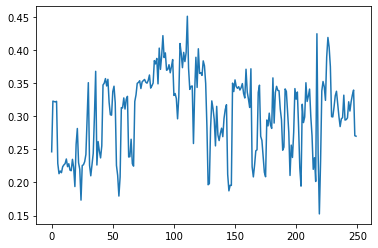

In [302]:
import matplotlib.pyplot as plt
plt.plot(y_pred[0])


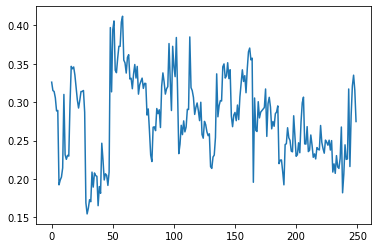

In [303]:
plt.plot(y_pred[1])

In [308]:
count = sum(1 for x in y_pred if len(x) == 0)
count

0

In [309]:
len(y_pred)

556

In [310]:
for i in range(len(vit_features)):
        vit_features[i] = torch.tensor(vit_features[i])

In [311]:
vit_features.shape

(556,)

In [312]:
vit_features[0].shape

torch.Size([250, 768])

In [313]:
vit_features

array([tensor([[ 0.1669, -0.1395, -0.2819,  ...,  0.5096,  0.0655, -0.2244],
        [ 0.0105, -0.1503, -0.3656,  ...,  0.4602,  0.0502, -0.1978],
        [ 0.0118, -0.1481, -0.3660,  ...,  0.4610,  0.0506, -0.1964],
        ...,
        [ 0.3850, -0.5600, -0.6787,  ...,  0.4260,  0.0365,  0.1725],
        [ 0.3852, -0.4697, -0.6354,  ...,  0.4633,  0.1463,  0.1468],
        [ 0.3544, -0.5640, -0.6265,  ...,  0.5150,  0.0950,  0.0053]]),
       tensor([[ 0.4236, -0.5999, -0.6260,  ...,  0.4318,  0.1195,  0.1378],
        [ 0.4246, -0.5730, -0.6514,  ...,  0.4142,  0.0605,  0.1623],
        [ 0.3720, -0.5122, -0.6938,  ...,  0.3501, -0.0527,  0.1567],
        ...,
        [ 0.3798, -0.4317, -0.2874,  ...,  0.2015,  0.3287,  0.1401],
        [ 0.2471, -0.2665, -0.2634,  ...,  0.2268,  0.3390,  0.1353],
        [ 0.5022, -0.5350, -0.3248,  ...,  0.3485,  0.3339,  0.1315]]),
       tensor([[ 0.6366, -0.3779, -0.0191,  ...,  0.4204,  0.5494,  0.2026],
        [ 0.3316, -0.5669, -0.4951,  ..

## model save

In [314]:
np.save('/workspace/EmotionShortForm/data_concatenate/concatenate_vit_features_array.npy',vit_features)

In [315]:
%pwd

'/workspace/EmotionShortForm/vit'

In [ ]:
#sns.displot(y_pred) ## to see the y_pred plot